# Projektaufgabe Python - Grundlagen, Webscraping und Datenanalyse

In [4]:
# Importieren der benötigten packages
import pandas as pd
import numpy as np
from numpy.linalg import inv
import scipy 
import matplotlib.pyplot as plt
from sklearn.utils import resample
from numpy.linalg import pinv
import statsmodels.api as sm
import math
import itertools

In [5]:
# Initieren der Klasse RegressionAnalysis mit den Methoden fit_OLS und bootstrap, um später die OLS-Regression und das Bootstrap Verfahren damit durchzuführen
class RegressionAnalysis:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def fit_OLS(self):
        model = sm.OLS(self.y, self.X)
        results = model.fit()
        return results

    def bootstrap(self, B=199):
        nobs = len(self.y)
        boot_means = np.zeros(B)
        for i in range(B):
            idx = np.random.randint(0, nobs, nobs)
            if isinstance(self.X, pd.DataFrame):
                sample_X = self.X.iloc[idx]
            else:
                sample_X = self.X[idx]

            if isinstance(self.y, (pd.Series, pd.DataFrame)):
                sample_y = self.y.iloc[idx]
            else:
                sample_y = self.y[idx]

            sample_model = sm.OLS(sample_y, sample_X)
            sample_results = sample_model.fit()
            boot_means[i] = np.mean(sample_X @ sample_results.params)
        return np.std(boot_means)

3.1 Datensätze: Importieren der Datensätze und Benennung der Variablen

In [6]:
column_names = ['treatment', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 'RE74', 'RE75', 'RE78']
psid = pd.read_csv("psid_controls.txt", sep='\s+', names = column_names)

treated = pd.read_csv("nswre74_treated.txt", sep='\s+', names = column_names)

Die Datensätze 'psid' für die Kontrollgruppe und 'treated' für die Teilnehmer des Beschäftigungsprogramms werden importiert, die Namen der Variablen werden durch 'column_names' zugeordnet. Insgesamt liegen 2490 Beobachtungen für 'psid' und 185 Beobachtungen für 'treated' vor.

# 4 Analyse

4.1 Datenaufbereitung

In [7]:
# 'hispanic' und 'RE74' werden nicht benötigt

psid.drop(["hispanic", "RE74"], axis=1, inplace=True)
treated.drop(["hispanic", "RE74"], axis=1, inplace=True)

In [8]:
# Nur die Beobachtungen für Afroamerikaner werden beibehalten
psid = psid[psid["black"]==1]
treated = treated[treated["black"]==1]

df_combined = pd.concat([psid, treated])

Da die Variablen 'hispanic' und 'RE74' nicht benötigt werden, werden diese aus den Datensätzen entfernt. Ausserdem werden nur die Beobachtungen für 780 Afroamerikaner betrachtet, weshalb diese Variable den Wert 1 haben muss. 
Zuletzt wird noch ein Kombiniertes Dataframe erstellt, weches innerhalb der nächsten Aufgabe benötigt wird.

4.2 Schätzverfahren für empirische Daten

4.2.1 Algorithmus

In [9]:
# N_1 definieren
N_1 = (df_combined['treatment'] == 1).sum()
print("Anzahl der Einsen in der Spalte 'treatment':", N_1)

#N_0 definieren
N_0 = (df_combined['treatment'] == 0).sum()
print("Anzahl der Nullen in der Spalte 'treatment':", N_0)

Anzahl der Einsen in der Spalte 'treatment': 156
Anzahl der Nullen in der Spalte 'treatment': 624


N_1 ist die Anzahl der Programmteilnehmer, N_0 die Anzahl der Nicht-Teilnehmer bzw. Kontrollgruppe.

In [10]:
# Dataframe X erstellen
X = df_combined[['age', 'education', 'married', 'nodegree', 'RE75','treatment']]
X.insert(0, 'const', 1)
X

,const,age,education,married,nodegree,RE75,treatment
1,1,50.0,12.0,1.0,0.0,0.00,0.0
3,1,28.0,12.0,1.0,0.0,0.00,0.0
7,1,25.0,12.0,0.0,0.0,0.00,0.0
9,1,50.0,12.0,1.0,0.0,0.00,0.0
10,1,23.0,12.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...
180,1,33.0,12.0,1.0,0.0,10941.35,1.0
181,1,25.0,14.0,1.0,0.0,11536.57,1.0
182,1,35.0,9.0,1.0,1.0,13830.64,1.0
183,1,35.0,8.0,1.0,1.0,17976.15,1.0


X ist eine 780x7 Matrix, die in der ersten Spalte 'const' einen Vektor mit Einsen enthält.

In [11]:
# Teilmatrixen von X erstellen 
X1 = X[X["treatment"]==1]
X0 = X[X["treatment"]==0]
X1 = X1[['const','age', 'education', 'married', 'nodegree', 'RE75']]
X0 = X0[['const','age', 'education', 'married', 'nodegree', 'RE75']]
X = X[['const','age', 'education', 'married', 'nodegree', 'RE75']]

In [12]:
X

,const,age,education,married,nodegree,RE75
1,1,50.0,12.0,1.0,0.0,0.00
3,1,28.0,12.0,1.0,0.0,0.00
7,1,25.0,12.0,0.0,0.0,0.00
9,1,50.0,12.0,1.0,0.0,0.00
10,1,23.0,12.0,0.0,0.0,0.00
...,...,...,...,...,...,...
180,1,33.0,12.0,1.0,0.0,10941.35
181,1,25.0,14.0,1.0,0.0,11536.57
182,1,35.0,9.0,1.0,1.0,13830.64
183,1,35.0,8.0,1.0,1.0,17976.15


X1 und X0 stellen die Teilmatrizen von X dar, in denen auf Programmteilnehmer und Nichtteilnehmer gefiltert wurde. Das neu definierte X stellt nun die in 4.2.1 beschriebene Matrix mit der Dimension 780x6 dar.

In [13]:
y = df_combined[['treatment','RE78']]
y1 = y[y["treatment"]==1]
y0 = y[y["treatment"]==0]
y1 = y1["RE78"]
y0 = y0["RE78"]
y1 = pd.DataFrame(y1, columns=["RE78"])
y0 = pd.DataFrame(y0, columns=['RE78'])

y1 und y0 beinhalten die abhängige Variable 'RE78', jeweils für Teilnehmer und Nicht-Teilnehmer.

In [14]:
# Erstellen von Instanzen der RegressionAnalysis-Klasse und Durchführung der OLS-Regression
reg_analysis_1 = RegressionAnalysis(X1, y1)
b1 = reg_analysis_1.fit_OLS()

reg_analysis_0 = RegressionAnalysis(X0, y0)
b0 = reg_analysis_0.fit_OLS()

b1 und b0 sind die OLS-Steigungskoeffizienten für Teilnehmer und Nicht-Teilnehmer.

In [15]:
# Umwandlung zu numpy arrays
b0 = b0.params.to_numpy()
b1 = b1.params.to_numpy()
X_numpy = X.to_numpy()

In [16]:
# Berechnung der Effekte
mu1 = X_numpy @ b1
mu0 = X_numpy @ b0

mu1 und mu0 stellen den Wert der abhängigen Variable 'RE78' für Teilnehmer bzw. Nicht-Teilnehmer dar.

In [17]:
# Berechnung des Lohneffektes nur für die letzten 156 Werte
#Filtern nach den 156 letzten Werte
mu1_lohneffekt = mu1[-156:]
mu0_lohneffekt = mu0[-156:]

In [18]:
#Lohneffekt berechnen
thetha  = np.mean(mu1_lohneffekt-mu0_lohneffekt)
thetha

1246.0455271387827

In [47]:
lohneffekt = mu1_lohneffekt - mu0_lohneffekt

theta ist der durchschnittlichen Lohneffekt des Beschäftigungprogramms.

4.2.2 Bootstrap-Standardfehler

In [21]:
# Initialisierung des Zufallsgenerators und Durchführung des Bootstrapping mit der .bootstrap() Methode
np.random.seed(456)
reg_analysis_lohneffekt = RegressionAnalysis(X, lohneffekt)
sigma = reg_analysis_lohneffekt.bootstrap()
print(f' Der Bootstrap-Standardfehler bei 199 Wiederholungen beträgt {round(sigma, 2)}.')

 Der Bootstrap-Standardfehler bei 199 Wiederholungen beträgt 181.37.


4.3 Datensimulation

4.3.1 Datenaufbereitung

In [22]:
# Dataframe X erstellen
X = df_combined[['age', 'education', 'married', 'nodegree', 'RE75']]
X = sm.add_constant(X)  # Hinzufügen einer Konstanten
y = df_combined['treatment']
X

,const,age,education,married,nodegree,RE75
1,1.0,50.0,12.0,1.0,0.0,0.00
3,1.0,28.0,12.0,1.0,0.0,0.00
7,1.0,25.0,12.0,0.0,0.0,0.00
9,1.0,50.0,12.0,1.0,0.0,0.00
10,1.0,23.0,12.0,0.0,0.0,0.00
...,...,...,...,...,...,...
180,1.0,33.0,12.0,1.0,0.0,10941.35
181,1.0,25.0,14.0,1.0,0.0,11536.57
182,1.0,35.0,9.0,1.0,1.0,13830.64
183,1.0,35.0,8.0,1.0,1.0,17976.15


In [23]:
# Durchführung der Logit-Regression
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

# Anzeigen der Ergebnisse
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.225208
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  780
Model:                          Logit   Df Residuals:                      774
Method:                           MLE   Df Model:                            5
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.5499
Time:                        10:32:51   Log-Likelihood:                -175.66
converged:                       True   LL-Null:                       -390.31
Covariance Type:            nonrobust   LLR p-value:                 1.429e-90
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3900      1.244      0.313      0.754      -2.049       2.829
age           -0.0525      0.

In [24]:
# Erstellen der neuen "treatment_new" Variable
# Extrahieren der Logit-Koeffizienten
logit_coefs = logit_result.params.values

# Berechnen des logit-basierten Scores für jede Beobachtung
logit_score = X @ logit_coefs

# Erstellen der neuen Treatment-Variable basierend auf dem logit-basierten Score
treatment_new = (logit_score > 0).astype(int)

# Hinzufügen von treatment_new zu X
X['treatment_new'] = treatment_new

Die Logit-Regression wird durchgeführt, um basierend auf den Logit-Koeffizienten die neue Variable 'treatment_new' zu erstellen. Diese wird zu X hinzugefügt.

In [25]:
X

,const,age,education,married,nodegree,RE75,treatment_new
1,1.0,50.0,12.0,1.0,0.0,0.00,0
3,1.0,28.0,12.0,1.0,0.0,0.00,0
7,1.0,25.0,12.0,0.0,0.0,0.00,1
9,1.0,50.0,12.0,1.0,0.0,0.00,0
10,1.0,23.0,12.0,0.0,0.0,0.00,1
...,...,...,...,...,...,...,...
180,1.0,33.0,12.0,1.0,0.0,10941.35,0
181,1.0,25.0,14.0,1.0,0.0,11536.57,0
182,1.0,35.0,9.0,1.0,1.0,13830.64,0
183,1.0,35.0,8.0,1.0,1.0,17976.15,0


In [26]:
# Zurücksetzen des Index von X und Löschen der tatsächlichen 156 Programmteilnehmer für X0
X = X.reset_index(drop=True)
X0 = X[:N_0]

In [27]:
X0

,const,age,education,married,nodegree,RE75,treatment_new
0,1.0,50.0,12.0,1.0,0.0,0.000,0
1,1.0,28.0,12.0,1.0,0.0,0.000,0
2,1.0,25.0,12.0,0.0,0.0,0.000,1
3,1.0,50.0,12.0,1.0,0.0,0.000,0
4,1.0,23.0,12.0,0.0,0.0,0.000,1
...,...,...,...,...,...,...,...
619,1.0,51.0,8.0,1.0,1.0,25064.516,0
620,1.0,52.0,8.0,1.0,1.0,33120.968,0
621,1.0,41.0,8.0,1.0,1.0,32888.226,0
622,1.0,48.0,8.0,1.0,1.0,26854.839,0


X0 beinhaltet nun alle Beobachtungen für Nicht-Teilnehmer mit der neuen Variable 'treatment_new'.

4.3.2 Simulation

In [28]:
# Anzahl der Wiederholungen der Montecarlo Simulationen
REPL = 100

In [29]:
# Werte, die die Variablen annehmen können
married_values = [0, 1]
nodegree_values = [0, 1]
treatment_new_values = [0, 1]

# Erstellung eines Dictionary, um die Indizes zu speichern (Nutzung einer List Comprehension)
indices = {f'index{married}{nodegree}{treatment_new}': X0[(X0['married'] == married) & (X0['nodegree'] == nodegree) & (X0['treatment_new'] == treatment_new)].index 
           for married, nodegree, treatment_new in itertools.product(married_values, nodegree_values, treatment_new_values)}

Die Indizes der acht möglichen Gruppen der binären Variablen für 'married', 'nodegree' und 'treatment_new' werden in einem Dictionary gespeichert, der Schlüssel ist dabei die Kombination der binären Werte.

In [30]:
# Min und Max Werte identifizieren, damit diese als Ober- und Untergrenze für die Simulation verwendet werden können
min_age = X0['age'].min()
max_age = X0['age'].max()

min_education = X0['education'].min()
max_education = X0['education'].max()

min_RE75 = X0['RE75'].min()
max_RE75 = X0['RE75'].max()

Min- und Max-Werte der empirischen Daten für Ober- und Untergrenze der simulierten Werte.

In [31]:
# Dictionary, um die Mittelwerte und Kovarianzen zu speichern
means = {}
covariances = {}

# Spaltenindizes
columns = [1, 2, 5]

for married, nodegree, treatment_new in itertools.product(married_values, nodegree_values, treatment_new_values):
    # Keys
    key_mean = f'mean{married}{nodegree}{treatment_new}'
    key_cov = f'cov{married}{nodegree}{treatment_new}'

    # Index 
    index_key = f'index{married}{nodegree}{treatment_new}'

    # Prüfe, ob der Index existiert und nicht leer ist
    if index_key in indices and not indices[index_key].empty:
        selected_data = X0.iloc[indices[index_key], columns]
        means[key_mean] = selected_data.mean()
        covariances[key_cov] = selected_data.cov()
    else:
        # Für Kombinationen, die keine Daten haben
        means[key_mean] = None
        covariances[key_cov] = None

Erstellung von Dictionaries für die Mittelwerte und Kovarianzen der der empirischen Werte. Falls ein Index nicht existiert, wird als Wert 'None' verwendet.

Alle möglichen der unabhängigen Variablen 'age', 'education' und 'RE75' werden mit den Index-Werten bestimmt. Die Min- und Max-Werte dienen als Unter- und Obergrenze in der Simulation, die Mittelwerte und Kovarianzen werden für die Simulation selbst verwendet.

In [32]:
# Erste Monte-Carlo Simulation
np.random.seed(123456)  # Initialisierung des Zufallsgenerators.
# Vorbereitungen
stat_MC = np.zeros((REPL))
# Anzahl der Spalten mit shape
anzahl_spalten = X0.shape[1]
# Converten für den for loop
X0_treatment = X0.copy() #enthält noch treatment_new da es gleich rausfliegt
X0 = X0[['const','age', 'education', 'married', 'nodegree', 'RE75']]
X1_array = X1.to_numpy()
y1_array = y1.to_numpy()
X0_array = X0.to_numpy()
y0_array = y0.to_numpy()

In [33]:
# Initialisierung der Listen zur Speicherung der Statistiken, Vorbereitung für 4.4
coefficients = []
standard_errors = []
t_values = []
p_values = []

In [34]:
X

,const,age,education,married,nodegree,RE75,treatment_new
0,1.0,50.0,12.0,1.0,0.0,0.00,0
1,1.0,28.0,12.0,1.0,0.0,0.00,0
2,1.0,25.0,12.0,0.0,0.0,0.00,1
3,1.0,50.0,12.0,1.0,0.0,0.00,0
4,1.0,23.0,12.0,0.0,0.0,0.00,1
...,...,...,...,...,...,...,...
775,1.0,33.0,12.0,1.0,0.0,10941.35,0
776,1.0,25.0,14.0,1.0,0.0,11536.57,0
777,1.0,35.0,9.0,1.0,1.0,13830.64,0
778,1.0,35.0,8.0,1.0,1.0,17976.15,0


In [41]:
# Durchführen der Simulationen und Berechnung der OLS-Statistiken für 4.4

for i in range(REPL):
    X0_sim = X0.copy()

    for married, nodegree, treatment_new in itertools.product(married_values, nodegree_values, treatment_new_values):
            key = f'index{married}{nodegree}{treatment_new}'
            key_mean = f'mean{married}{nodegree}{treatment_new}'
            key_cov = f'cov{married}{nodegree}{treatment_new}'

            if indices[key].empty or means[key_mean] is None or covariances[key_cov] is None:
                continue

            X0_sim.iloc[indices[key], [1, 2, 5]] = np.random.multivariate_normal(means[key_mean], covariances[key_cov], len(indices[key]))

    #Ganze Werte
    X0_sim[['age','education']] = X0_sim[['age','education']].astype(int)
    
    #Max festlegen
    X0_sim['age'] = X0['age'].apply(lambda x: max_age if x > max_age else x)
    X0_sim['education'] = X0['education'].apply(lambda x: max_education if x > max_education else x)
    X0_sim['RE75'] = X0['RE75'].apply(lambda x: max_RE75 if x > max_RE75 else x)
    #Min festlegen
    X0_sim['age'] = X0['age'].apply(lambda x: min_age if x < min_age else x)
    X0_sim['education'] = X0['education'].apply(lambda x: max_education if x < max_education else x)
    X0_sim['RE75'] = X0['RE75'].apply(lambda x: min_RE75 if x < min_RE75 else x)
    
    # Berechnen thetha sim
    ## Teil mit Wurzel:
    i_1 = math.sqrt(1/(N_1-anzahl_spalten-1) * np.sum((X1_array @ b1-y1_array)**2))
    i_0 = math.sqrt(1/(N_0-anzahl_spalten-1) * np.sum((X0_array @ b0-y0_array)**2))

    ## u und v 
    u = np.random.randn(624) 
    v = np.random.randn(624)
    
    X0_sim_array = X0_sim.to_numpy()

    mu_sim_1 = np.array(X0_sim @ b1) + u * i_1
    mu_sim_0 = np.array(X0_sim @ b0) + v * i_0
    
    X0_treatment['mu_sim_1'] = mu_sim_1
    X0_treatment['mu_sim_0'] = mu_sim_0
    
    # Bedingungen für die Zuweisung
    bedingung_1 = X0_treatment['treatment_new'] == 1
    bedingung_0 = ~bedingung_1

    # Werte in der Spalte RE78 entsprechend den Bedingungen setzen
    X0_treatment['RE78'] = 0  # Initialisiere die Spalte mit 0
    X0_treatment.loc[bedingung_1, 'RE78'] = X0_treatment.loc[bedingung_1, 'mu_sim_1']
    X0_treatment.loc[bedingung_0, 'RE78'] = X0_treatment.loc[bedingung_0, 'mu_sim_0']
    
    stat_MC[i] = sum(X0_sim.mean())

    X0_sim['treatment_new'] = X0_treatment['treatment_new']

    # Durchführen der OLS-Regression
    reg_analysis = RegressionAnalysis(X0_sim, X0_treatment['RE78'])
    ols = reg_analysis.fit_OLS()
    
    # Speichern der Statistiken
    coefficients.append(ols.params)
    standard_errors.append(ols.bse)
    t_values.append(ols.tvalues)
    p_values.append(ols.pvalues)  

Durchführung der 100 Simulationen. Neben den eigentlichen Datensimulationen wird in jeder Iteration des for-loops auch eine OLS-Regression durchgeführt und die für Aufgabe 4.4 benötigten Statistiken in Listen angehängt. 

4.3 Schätzverfahren für simulierte Daten

In [44]:
# Konvertierung der Listen in DataFrames
df_coefficients = pd.DataFrame(coefficients)
df_standard_errors = pd.DataFrame(standard_errors)
df_t_values = pd.DataFrame(t_values)
df_p_values = pd.DataFrame(p_values)

# Berechnung der Mittelwerte der Statistiken
mean_coefficients = df_coefficients.mean()
mean_standard_errors = df_standard_errors.mean()
mean_t_values = df_t_values.mean()
mean_p_values = df_p_values.mean()

# Erstellen einer Tabelle mit den Mittelwerten
ols_stats = pd.DataFrame({
    "Mean Coefficients": mean_coefficients,
    "Mean Standard Errors": mean_standard_errors,
    "Mean t-Values": mean_t_values,
    "Mean p-Values": mean_p_values
})

ols_stats

,Mean Coefficients,Mean Standard Errors,Mean t-Values,Mean p-Values
const,48.358002,202.782043,0.237206,0.503172
age,-142.257084,1565.891537,-0.088055,0.477327
education,822.086033,3447.294728,0.237206,0.503172
married,4130.236601,38075.481955,0.107112,0.496058
nodegree,-4306.927589,33381.180981,-0.130504,0.541830
RE75,0.587895,1.714623,0.343265,0.481315
treatment_new,1253.822502,72890.489895,0.017693,0.689176


In [45]:
# Berechnung des Anteils der Simulationen mit p < 0.05
significant_results = np.mean([p < 0.05 for p in p_values])
print(f' Insgesamt haben {round(significant_results*100, 2)}% der Simulationen einen p-Wert < 0.05.')

 Insgesamt haben 5.21% der Simulationen einen p-Wert < 0.05.


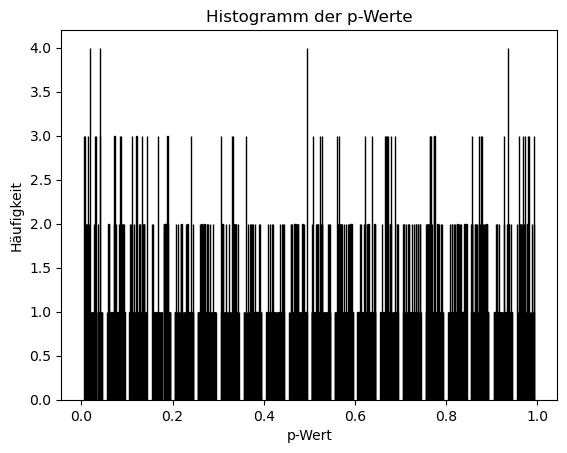

In [46]:
# Erstellen eines Histogramms der p-Werte
plt.hist(p_values, bins=20, edgecolor='black')
plt.xlabel('p-Wert')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der p-Werte')
plt.show()

Aufgabenaufteilung innerhalb der Gruppe:
Grundsätzlich hat jeder die Aufgabe zunächst für sich bearbeitet, um ein Verständnis zu gewinnen. Anschliessend wurden in der Gruppe offene Fragen besprochen und die Lösungen verglichen. Im anschliessenden Bearbeitungsprozess lag der Schwerpunkt der Bearbeitung der einzelnen Gruppenmitglieder wie folgt:

4.1 Datenaufbereitung: Sören Schlißke

4.2 Schätzverfahren für die empirischen Daten

4.2.1 Algorithmus: Maximilien Gantner

4.2.2 Bootstrap-Standardfehler: Sören Schlißke

4.3 Datensimulation: Maximilien Gantner

4.4 Schätzverfahren für die simulierten Daten: Sören Schlißke

Gruppenarbeit von Maximilien Gantner und Sören Schlißke